In [1]:
import asyncio
import datetime as dt
import math
from typing import Literal

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [2]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [3]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [4]:
from fetching_from_local_db.enums import AssetClass, Index, StrikeSpread
from fetching_from_local_db.fetch_from_db import _fetch_batch, fetch_data, fetch_spot_data

In [5]:
from expiries import dict_expiries

In [6]:
def resample(
    data: pl.DataFrame, timeframe, offset: dt.timedelta | None = None
) -> pl.DataFrame:
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(
            [
                pl.col("o").first().alias("o"),
                pl.col("h").max().alias("h"),
                pl.col("l").min().alias("l"),
                pl.col("c").last().alias("c"),
                # pl.col("volume").sum().alias("volume"),
            ]
        )
    )


# ohlc_resampled = resample(pl.DataFrame(bnf_1min), '7d', pd.Timedelta(days=4))
# ohlc_resampled

In [7]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2026),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe

    # Iterate over each year
    for year in range(2019, 2026):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()

        # Calculate total number of trades
        total_trades = len(year_trades)

        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100

        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()

        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f"{variation}"

        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]

    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0][
        "ROI%"
    ].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum()
        - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio: stats_df8}

In [8]:
bnf_1min = pd.read_csv("../data/nifty_min.csv")

In [9]:
bnf_1min.columns = ['index', 'datetime', 'o', 'h', 'l', 'c', 'v']
# bnf_1min.tail()

In [10]:
bnf_1min["datetime"] = pd.to_datetime(bnf_1min["datetime"]).dt.tz_localize(None)
# bnf_1min = bnf_1min[((bnf_1min['datetime'].dt.year == 2020) & (bnf_1min['datetime'].dt.month == 4))]
bnf_1min = bnf_1min[
    (bnf_1min["datetime"].dt.year >= 2019) & (bnf_1min["datetime"].dt.year <= 2025)
]

In [11]:
# dict_expiries

In [12]:
from datetime import date
from bisect import bisect_left

def get_next_expiry(input_date, index_symbol):
    expiries = dict_expiries.get(index_symbol)
    if not expiries:
        return None
        
    expiry_dates = sorted({dt.date() for dt in expiries})
    pos = bisect_left(expiry_dates, input_date)
    return expiry_dates[pos] if pos < len(expiry_dates) else None


In [13]:
index_ = 'nifty'

if index_ == 'nifty':
    LOT_SIZE_ = 75
    STRIKE_SPREAD_ = 50
    INDEX_LEVERAGE_ = 8
    PORTFOLIO_ = 1_00_00_000

In [14]:
import pandas as pd

async def add_atr(df, period=14):
    """
    Adds an 'ATR' column to the DataFrame using Wilder's smoothing (like TradingView).
    
    Parameters:
    df (pd.DataFrame): Must contain 'h', 'l', 'c' columns for high, low, close
    period (int): ATR period (default 14)
    
    Returns:
    pd.DataFrame: With 'ATR' column added
    """
    high = df['h']
    low = df['l']
    close = df['c']

    # True Range
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR with Wilder's smoothing (like an EMA with alpha=1/period)
    atr = tr.ewm(alpha=1/period, adjust=False).mean()

    df['ATR'] = atr
    return df


In [15]:
async def send_trade(spot_price, entry_timestamp, expiry, direction, atr, tf, offset, dte, tradebook, trade_num, spot_level):
    if direction == 1:
        opt_type = 'P'
        side = 'LONG'
    elif direction == -1:
        opt_type = "C"
        side = 'SHORT'
    else:
        return tradebook

    current_date = entry_timestamp.date()
    current_time = entry_timestamp.time()

    strike = int(round(spot_price / STRIKE_SPREAD_) * STRIKE_SPREAD_) if opt_type == 'C' else int(round(spot_price / STRIKE_SPREAD_) * STRIKE_SPREAD_)

    option_df = await fetch_data(
        index=index_,
        expiry=expiry,
        strike=strike,
        asset_class=opt_type,
        start_date=current_date,
        start_time=entry_timestamp.time(),
        end_date=current_date,
        end_time=dt.time(15, 30),
    )

    if option_df is not None and not isinstance(option_df, str):
        option_df = resample(option_df, tf, offset)
        option_df_pandas = option_df.to_pandas()
        entry_price = option_df_pandas.iloc[0]['c']
    else:
        entry_price = float('nan')

    # print(f'{entry_timestamp} : {side} TRADE Entered ! ')

    trade = {
        'date': current_date,
        # 'high level': high_level,
        # 'low level': low_level,
        # 'atr_multiplier': multiplier,
        'Morning ATR': atr,
        'side': side,
        'strike': strike,
        'type': opt_type,
        'expiry': expiry,
        'dte': dte,
        'entry_time': current_time,
        'entry price': entry_price,
        'trade_num': trade_num,
        'spot_price_at_entry': spot_level,
    }
        
    tradebook.append(trade)
    return tradebook

async def take_exit(strike, opt_type, expiry, exit_timestamp, tf, offset, tradebook, trade_num, spot_level):

    current_date = exit_timestamp.date()
    current_time = exit_timestamp.time()

    strike = int(round(strike / STRIKE_SPREAD_) * STRIKE_SPREAD_) if opt_type == 'C' else int(round(strike / STRIKE_SPREAD_) * STRIKE_SPREAD_)

    if opt_type == 'P':
        side = 'LONG'
    elif opt_type == 'C':
        side = 'SHORT'
    else:
        side = 'None'

    for trade in tradebook:
        if (
            trade['type'] == opt_type and
            trade['date'] == current_date and
            'exit_time' not in trade
        ):
            option_df = await fetch_data(
                index=index_,
                expiry=expiry,
                strike=strike,
                asset_class=opt_type,
                start_date=current_date,
                start_time=current_time,
                end_date=current_date,
                end_time=dt.time(15, 30),
            )
            # print(option_df)
            if option_df is not None and not isinstance(option_df, str):
                option_df = resample(option_df, tf, offset)
                option_df_pandas = option_df.to_pandas()
                exit_price = option_df_pandas.iloc[0]['c']
                # print(f'{side} Trade Exited')
            else:
                exit_price = float('nan')

            if current_time > dt.time(15, 20):
                remark = 'EOD Exit'
            else:
                remark = 'TSL Hit'

            # print(f'{exit_timestamp} : {side} {remark}')

            if option_df is not None and not isinstance(option_df, str):
                trade['exit price'] = exit_price
                trade['exit_time'] = option_df_pandas['datetime'].iloc[0] if len(option_df_pandas) != 0 else float('nan')
                trade['spot_level_at_exit'] = spot_level
                trade['remarks'] = remark
                # trade['high level at exit'] = high_level
                # trade['low level at exit'] = low_level
                trade['points'] = trade['entry price'] - trade['exit price']
            else:
                trade['exit price'] = float('nan')
                trade['exit_time'] = float('nan')
                trade['spot_level_at_exit'] = spot_level
                trade['remarks'] = remark
                # trade['high level at exit'] = high_level
                # trade['low level at exit'] = low_level
                trade['points'] = trade['entry price'] - trade['exit price']

    return tradebook

In [18]:
async def backtest_intraday_levels2(df, multiplier, tf, offset):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df[df['datetime'].dt.year >= 2025]
    df['date'] = df['datetime'].dt.date
    # print(df.head().to_string())
    
    tradebook = []

    eod_time = dt.time(15, 20)
    no_more_trade_time = dt.time(15, 0)
    allowed_dte = [0, 1, 2, 3, 6]

    for date, group in df.groupby('date'):
        current_date = date
        group = group.reset_index(drop=True)
        print(date)
        # Get 9:15 candle
        morning_candle = group[group['datetime'].dt.time == pd.to_datetime("09:15").time()]
        if morning_candle.empty:
            continue

        morning_atr = morning_candle.iloc[0]['ATR']
        running_high = group.iloc[0]['h'] # Initialising
        running_low = group.iloc[0]['l'] # Initialising

        is_high_breached = False
        is_low_breached = False

        in_trade_long = False
        in_trade_short = False

        data_fetched_pe = False
        data_fetched_ce = False

        trade_num = 1
        max_trades = 25

        for i in range(0, len(group)):
            row = group.iloc[i]
            previous_row = group.iloc[i-1]
            running_high = max(running_high, row['h'])
            running_low = min(running_low, row['l'])
            
            current_datetime = row['datetime']
            
            high_level = running_low + (multiplier * morning_atr)
            low_level = running_high - (multiplier * morning_atr)
            
            long_tsl = low_level
            short_tsl = high_level
            
            # print(row)
            # print(group.iloc[i]['datetime'], high_level, low_level, row['c'])
            # print(f'RH : {running_high} , RL : {running_low}')

            # high_strike = int(round(high_level / STRIKE_SPREAD_) * STRIKE_SPREAD_)
            # low_strike = int(round(low_level / STRIKE_SPREAD_) * STRIKE_SPREAD_)

            expiry = get_next_expiry(date, index_)
            dte = (expiry - current_date).days            

            if not in_trade_long and not in_trade_short and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                if row['c'] >= high_level and trade_num <= max_trades:
                    tradebook = await send_trade(high_level, current_datetime, expiry, 1, morning_atr, tf, offset, dte, tradebook, trade_num, row['c'])
                    trade_num += 1
                    # is_high_breached = True
                    in_trade_long = True
                    long_tsl = low_level

            if in_trade_long:
                if row['c'] <= long_tsl:
                    # TSL Hit
                    tradebook = await take_exit(high_level, 'P', expiry, current_datetime, tf, offset, tradebook, trade_num, row['c'])
                    in_trade_long = False
                    # is_high_breached = False

                    # Send Short Trade
                    running_low = row['l']
                    # print(f'Running Low changed to {running_low}')
                    high_level = running_low + (multiplier * morning_atr)
                    # print(f'High Level changed to {high_level}')
                    if trade_num <= max_trades and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                        tradebook = await send_trade(long_tsl, current_datetime, expiry, -1, morning_atr, tf, offset, dte, tradebook, trade_num, row['c'])
                        trade_num += 1
                        long_tsl = float('inf')
                        short_tsl = high_level
                        in_trade_short = True
                        # is_low_breached = True
                    else:
                        continue
                    
                elif current_datetime.time() >= eod_time:
                    # EOD Exit
                    tradebook = await take_exit(high_level, 'P', expiry, current_datetime, tf, offset, tradebook, trade_num, row['c'])
    
                    in_trade_long = False
                    # is_high_breached = False
                    long_tsl = float('inf')

            if not in_trade_short and not in_trade_long and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                if row['c'] <= low_level and trade_num <= max_trades:
                    tradebook = await send_trade(low_level, current_datetime, expiry, -1, morning_atr, tf, offset, dte, tradebook, trade_num, row['c'])
                    trade_num += 1
                    
                    # is_low_breached = True
                    in_trade_short = True

            if in_trade_short:
                if row['c'] >= short_tsl:
                    # TSL Hit
                    tradebook = await take_exit(low_level, 'C', expiry, current_datetime, tf, offset, tradebook, trade_num, row['c'])
                    
                    in_trade_short = False
                    # is_low_breached = False

                    # Send Long Trade
                    running_high = row['h']
                    # print(f'Running High changed to {running_high}')
                    low_level = running_high - (multiplier * morning_atr)
                    # print(f'Low Level changed to {low_level}')
                    if trade_num <= max_trades and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                        tradebook = await send_trade(short_tsl, current_datetime, expiry, 1, morning_atr, tf, offset, dte, tradebook, trade_num, row['c'])
                        trade_num += 1
                        short_tsl = float('-inf')
                        long_tsl = low_level
                        in_trade_long = True
                        # is_high_breached = True
                    else:
                        continue

                elif current_datetime.time() >= eod_time:
                    # EOD Exit
                    tradebook = await take_exit(low_level, 'C', expiry, current_datetime, tf, offset, tradebook, trade_num, row['c'])

                    in_trade_short = False
                    # is_low_breached = False
                    short_tsl = float('-inf')

    tb = pd.DataFrame(tradebook)
    # if len(tb) > 0:
    #     tb['index_lev'] = 8  # default for all

    #     tb.loc[tb['dte'] == 0, 'index_lev'] = 10
    #     tb.loc[(tb['dte'].isin([2, 6])) & (tb['type'] == 'PE'), 'index_lev'] = 9
    #     tb.loc[(tb['dte'].isin([2, 6])) & (tb['type'] == 'CE'), 'index_lev'] = 4

    #     tb['exit_time'] = pd.to_datetime(tb['exit_time'])
    #     tb['slippage'] = 0.01 * (tb['entry price'] + tb['exit price'])
    #     tb['final_points'] = tb['points'] - tb['slippage']
    #     tb['portfolio'] = PORTFOLIO_
    #     tb['qty'] = tb['portfolio'] * tb['index_lev'] / tb['strike']
    #     tb['pnl'] = tb['final_points'] * tb['qty']
    #     tb['ROI%'] = tb['pnl'] * 100 / tb['portfolio']
    #     tb['Trade Year'] = tb['exit_time'].dt.year

    return tb

In [19]:
TF_ = '10m'
OFFSET_ = '5m'
ATR_WINDOW_ = 14
MULTIPLIER_ = 2
bnf_df = resample(pl.DataFrame(bnf_1min), TF_, OFFSET_)
bnf_df_pandas = bnf_df.to_pandas()
bnf_df_pandas = await add_atr(bnf_df_pandas, ATR_WINDOW_)
tb = await backtest_intraday_levels2(bnf_df_pandas, MULTIPLIER_, TF_, OFFSET_)
# tb

/tmp/ipykernel_1258/3611542821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


2025-01-01
2025-01-02
2025-01-03
2025-01-06
2025-01-07
2025-01-08
2025-01-09
2025-01-10
2025-01-13
2025-01-14
2025-01-15
2025-01-16
2025-01-17
2025-01-20
2025-01-21
2025-01-22
2025-01-23
2025-01-24
2025-01-27
2025-01-28
2025-01-29
2025-01-30
2025-01-31
2025-02-01
2025-02-03
2025-02-04
2025-02-05
2025-02-06
2025-02-07
2025-02-10
2025-02-11
2025-02-12
2025-02-13
2025-02-14
2025-02-17
2025-02-18
2025-02-19
2025-02-20
2025-02-21
2025-02-24
2025-02-25
2025-02-27
2025-02-28
2025-03-03
2025-03-04
2025-03-05
2025-03-06
2025-03-07
2025-03-10
2025-03-11
2025-03-12
2025-03-13
2025-03-17
2025-03-18
2025-03-19
2025-03-20
2025-03-21
2025-03-24
2025-03-25
2025-03-26
2025-03-27
2025-03-28
2025-04-01
2025-04-02
2025-04-03
2025-04-04
2025-04-07
2025-04-08
2025-04-09
2025-04-11
2025-04-15
2025-04-16
2025-04-17
2025-04-21
2025-04-22
2025-04-23
2025-04-24
2025-04-25
2025-04-28
2025-04-29
2025-04-30
2025-05-02
2025-05-05
2025-05-06
2025-05-07
2025-05-08
2025-05-09
2025-05-12
2025-05-13
2025-05-14
2025-05-15

In [20]:
if len(tb) > 0:
    tb['index_lev'] = 8  # default for all

    tb.loc[tb['dte'] == 0, 'index_lev'] = 10
    tb.loc[(tb['dte'].isin([2, 6])) & (tb['type'] == 'P'), 'index_lev'] = 9
    tb.loc[(tb['dte'].isin([2, 6])) & (tb['type'] == 'C'), 'index_lev'] = 3

    tb['exit_time'] = pd.to_datetime(tb['exit_time'])
    tb['slippage'] = 0.01 * (tb['entry price'] + tb['exit price'])
    tb['final_points'] = tb['points'] - tb['slippage']
    tb['portfolio'] = PORTFOLIO_
    tb['qty'] = tb['portfolio'] * tb['index_lev'] / tb['strike']
    tb['pnl'] = tb['final_points'] * tb['qty']
    tb['ROI%'] = tb['pnl'] * 100 / tb['portfolio']
    tb['Trade Year'] = tb['exit_time'].dt.year

In [25]:
tb_may = tb[-61:]
# tb[tb['Trade Year'] >= 2025].tail(65)
tb_may

,date,Morning ATR,side,strike,type,expiry,dte,entry_time,entry price,trade_num,spot_price_at_entry,exit price,exit_time,spot_level_at_exit,remarks,points,index_lev,slippage,final_points,portfolio,qty,pnl,ROI%,Trade Year
223,2025-05-02,42.7744,LONG,24400,P,2025-05-08,6,09:15:00,170.7500,1,24403.6500,138.5000,2025-05-02 10:25:00,24492.3000,TSL Hit,32.2500,9,3.0925,29.1575,10000000,3688.5246,107548.1557,1.0755,2025.0000
224,2025-05-02,42.7744,SHORT,24500,C,2025-05-08,6,10:25:00,200.9500,2,24492.3000,117.3000,2025-05-02 13:15:00,24354.1000,TSL Hit,83.6500,3,3.1825,80.4675,10000000,1224.4898,98531.6327,0.9853,2025.0000
225,2025-05-02,42.7744,LONG,24300,P,2025-05-08,6,13:15:00,153.7500,3,24354.1000,190.9000,2025-05-02 14:25:00,24299.1500,TSL Hit,-37.1500,9,3.4465,-40.5965,10000000,3703.7037,-150357.4074,-1.5036,2025.0000
226,2025-05-02,42.7744,SHORT,24350,C,2025-05-08,6,14:25:00,146.0000,4,24299.1500,144.0000,2025-05-02 15:25:00,24313.6500,EOD Exit,2.0000,3,2.9000,-0.9000,10000000,1232.0329,-1108.8296,-0.0111,2025.0000
227,2025-05-05,50.3905,LONG,24500,P,2025-05-08,3,10:25:00,114.1500,1,24504.0500,151.1000,2025-05-05 11:45:00,24422.8000,TSL Hit,-36.9500,8,2.6525,-39.6025,10000000,3265.3061,-129314.2857,-1.2931,2025.0000
228,2025-05-05,50.3905,SHORT,24450,C,2025-05-08,3,11:45:00,101.3000,2,24422.8000,108.0000,2025-05-05 15:25:00,24459.5000,EOD Exit,-6.7000,8,2.0930,-8.7930,10000000,3271.9836,-28770.5521,-0.2877,2025.0000
229,2025-05-06,28.8077,SHORT,24450,C,2025-05-08,2,09:15:00,83.3500,1,24437.7500,31.2500,2025-05-06 15:25:00,24335.9000,EOD Exit,52.1000,3,1.1460,50.9540,10000000,1226.9939,62520.2454,0.6252,2025.0000
230,2025-05-07,33.3138,LONG,24300,P,2025-05-08,1,09:15:00,75.9500,1,24359.9500,74.5000,2025-05-07 09:45:00,24326.0500,TSL Hit,1.4500,8,1.5045,-0.0545,10000000,3292.1811,-179.4239,-0.0018,2025.0000
231,2025-05-07,33.3138,SHORT,24400,C,2025-05-08,1,09:45:00,50.0000,2,24326.0500,57.0000,2025-05-07 10:25:00,24372.8500,TSL Hit,-7.0000,8,1.0700,-8.0700,10000000,3278.6885,-26459.0164,-0.2646,2025.0000
232,2025-05-07,33.3138,LONG,24350,P,2025-05-08,1,10:25:00,69.0000,3,24372.8500,70.7000,2025-05-07 11:45:00,24356.9500,TSL Hit,-1.7000,8,1.3970,-3.0970,10000000,3285.4209,-10174.9487,-0.1017,2025.0000


In [26]:
tb_may.to_csv('scalper_may.csv', index=False)

In [23]:
tb['ROI%'].sum()

773.011616134513

In [177]:
stats = generate_stats(tb, 'ATR Dynamic')
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,109.1563,522,50.9579,1.1667,-0.7859,-8.7944,12.4121,ATR Dynamic
2020,274.3075,589,54.4992,1.9992,-1.3710,-18.9987,14.4382,ATR Dynamic
2021,106.0451,612,50.4902,1.2715,-0.9467,-21.0988,5.0261,ATR Dynamic
2022,139.7454,556,53.5971,1.3295,-0.9940,-17.1861,8.1313,ATR Dynamic
2023,36.7819,601,48.2529,0.8606,-0.6842,-12.7855,2.8768,ATR Dynamic
2024,76.7475,677,48.1536,1.0651,-0.7706,-22.2215,3.4537,ATR Dynamic
2025,30.2279,180,58.8889,0.8815,-0.8542,-8.3276,3.6298,ATR Dynamic
Overall,773.0116,3737,50.9033,1.2690,-0.9107,-22.2215,34.7866,ATR Dynamic


In [130]:
stats = generate_stats(tb, 'ATR Dynamic')
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,109.1563,522,50.9579,1.1667,-0.7859,-8.7944,12.4121,ATR Dynamic
2020,274.3075,589,54.4992,1.9992,-1.3710,-18.9987,14.4382,ATR Dynamic
2021,106.0451,612,50.4902,1.2715,-0.9467,-21.0988,5.0261,ATR Dynamic
2022,139.7454,556,53.5971,1.3295,-0.9940,-17.1861,8.1313,ATR Dynamic
2023,36.7819,601,48.2529,0.8606,-0.6842,-12.7855,2.8768,ATR Dynamic
2024,76.7475,677,48.1536,1.0651,-0.7706,-22.2215,3.4537,ATR Dynamic
2025,30.2279,180,58.8889,0.8815,-0.8542,-8.3276,3.6298,ATR Dynamic
Overall,773.0116,3737,50.9033,1.2690,-0.9107,-22.2215,34.7866,ATR Dynamic


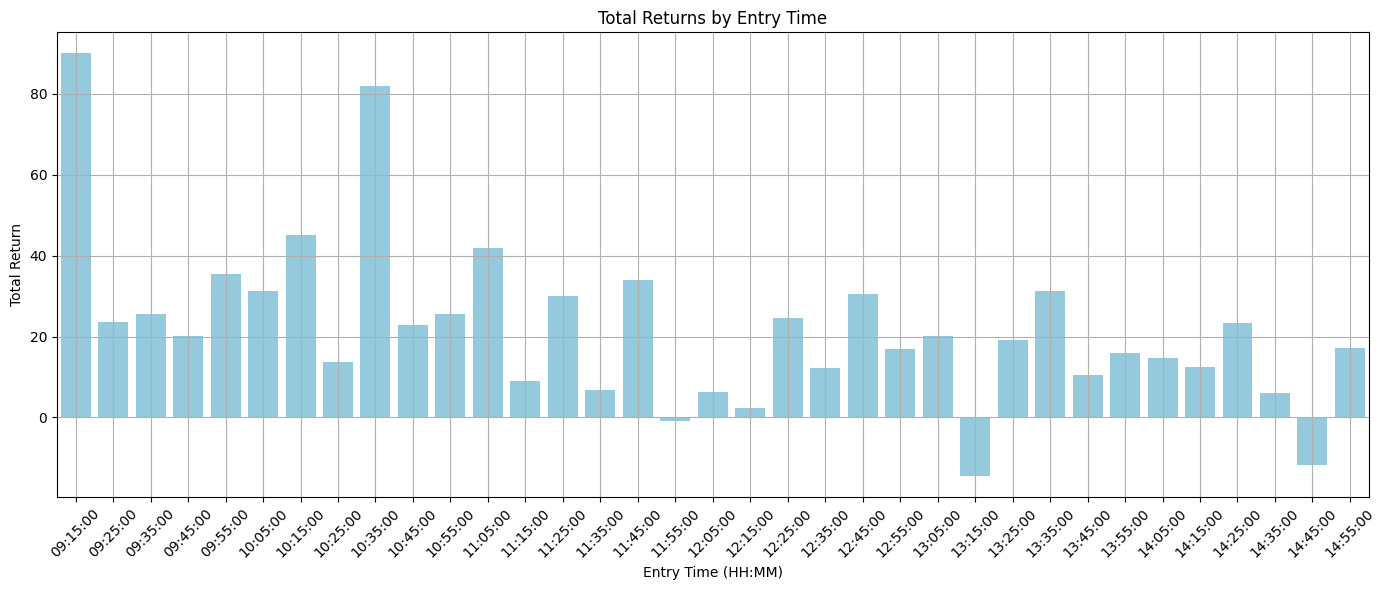

In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = tb.copy()  # your DataFrame

# Step 1: Convert time to string format (HH:MM) for better x-axis display
df['entry_time_str'] = df['entry_time'].apply(lambda t: t.strftime('%H:%M:%S'))

# Step 2: Group by time and sum the returns
agg_df = df.groupby('entry_time_str')['ROI%'].sum().reset_index()

# Step 3: Plot the summed returns by time
plt.figure(figsize=(14, 6))
sns.barplot(x='entry_time_str', y='ROI%', data=agg_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Returns by Entry Time')
plt.xlabel('Entry Time (HH:MM)')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [179]:
# tb.to_csv('ATR_Dynamic_JJMS_10m_14_2.csv', index=False)

In [180]:
# tb = tb_with_hedge
tb['Cumulative ROI%'] = tb['ROI%'].cumsum()
tb['Max Cumulative ROI%'] = tb['Cumulative ROI%'].cummax()  # Maximum value so far
tb['DD'] = tb['Cumulative ROI%'] - tb['Max Cumulative ROI%']  # Drawdown
tb.tail()

,date,Morning ATR,side,strike,type,expiry,dte,entry_time,entry price,trade_num,exit price,exit_time,remarks,points,index_lev,slippage,final_points,portfolio,qty,pnl,ROI%,Trade Year,Cumulative ROI%,Max Cumulative ROI%,DD
3759,2025-03-28,29.4007,SHORT,23550,C,2025-04-03,6,09:15:00,189.6500,1,227.3000,2025-03-28 10:25:00,TSL Hit,-37.6500,3,4.1695,-41.8195,10000000,1273.8854,-53273.2484,-0.5327,2025.0000,772.4525,772.9852,-0.5327
3760,2025-03-28,29.4007,LONG,23550,P,2025-04-03,6,10:25:00,93.9500,2,109.0000,2025-03-28 11:05:00,TSL Hit,-15.0500,9,2.0295,-17.0795,10000000,3821.6561,-65271.9745,-0.6527,2025.0000,771.7998,772.9852,-1.1855
3761,2025-03-28,29.4007,SHORT,23600,C,2025-04-03,6,11:05:00,156.5000,3,93.0000,2025-03-28 14:15:00,TSL Hit,63.5000,3,2.4950,61.0050,10000000,1271.1864,77548.7288,0.7755,2025.0000,772.5753,772.9852,-0.4100
3762,2025-03-28,29.4007,LONG,23500,P,2025-04-03,6,14:15:00,111.0000,4,98.1000,2025-03-28 14:55:00,TSL Hit,12.9000,9,2.0910,10.8090,10000000,3829.7872,41396.1702,0.4140,2025.0000,772.9892,772.9892,0.0000
3763,2025-03-28,29.4007,SHORT,23550,C,2025-04-03,6,14:55:00,116.7000,5,112.6500,2025-03-28 15:25:00,EOD Exit,4.0500,3,2.2935,1.7565,10000000,1273.8854,2237.5796,0.0224,2025.0000,773.0116,773.0116,0.0000


In [181]:
import pandas as pd

def calculate_dte_stats(df):
    # Check required columns
    # print(df.columns)
    if 'dte' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns or 'type' not in df.columns:
        raise ValueError("DataFrame must contain 'dte', 'ROI%', 'DD', and 'type' columns.")
    
    # Add win flag
    df['is_win'] = df['ROI%'] > 0

    # Group by both DTE and Option Type
    grouped_stats = df.groupby(['dte', 'type']).agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),
        total_trades=('dte', 'count'),
        wins=('is_win', 'sum')
    ).reset_index()

    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    # Calculate win rate
    grouped_stats['win_rate'] = (grouped_stats['wins'] / grouped_stats['total_trades']) * 100

    return grouped_stats


In [182]:
import pandas as pd

def calculate_opt_type_stats(df):

    # print(df.columns)
    if 'type' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns:
        raise ValueError("DataFrame must contain 'DTE', 'returns', and 'drawdown' columns.")
    
    # Group by DTE and calculate required stats
    grouped_stats = df.groupby('type').agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),  # Assuming 'drawdown' contains negative values
        total_trades=('type', 'count')
    ).reset_index()
    
    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    return grouped_stats


In [183]:
import pandas as pd

def calculate_trade_num_stats(df):

    # print(df.columns)
    if 'trade_num' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns:
        raise ValueError("DataFrame must contain 'DTE', 'returns', and 'drawdown' columns.")
    
    # Group by DTE and calculate required stats
    grouped_stats = df.groupby('trade_num').agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),  # Assuming 'drawdown' contains negative values
        total_trades=('trade_num', 'count')
    ).reset_index()
    
    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    return grouped_stats


In [184]:
stats_dte = calculate_dte_stats(tb)
stats_dte

,dte,type,returns_sum,max_drawdown,total_trades,wins,returns_to_max_dd_ratio,win_rate
0,0,C,127.0698,-20.9351,381,237,6.0697,62.2047
1,0,P,146.1979,-20.7619,395,237,7.0417,60.0000
2,1,C,54.3375,-22.2215,375,183,2.4453,48.8000
3,1,P,82.2688,-21.9634,408,202,3.7457,49.5098
4,2,C,15.5697,-20.8096,375,182,0.7482,48.5333
5,2,P,152.8115,-20.9452,411,208,7.2958,50.6083
6,3,C,51.4078,-21.0560,312,145,2.4415,46.4744
7,3,P,66.1636,-20.4069,321,169,3.2422,52.6480
8,6,C,8.6541,-20.1075,386,170,0.4304,44.0415
9,6,P,68.5310,-20.2386,400,183,3.3861,45.7500


In [185]:
stats_opt_type = calculate_opt_type_stats(tb)
stats_opt_type

,type,returns_sum,max_drawdown,total_trades,returns_to_max_dd_ratio
0,C,257.0389,-22.2215,1829,11.5671
1,P,515.9727,-21.9634,1935,23.4923


In [186]:
stats_trade_num = calculate_trade_num_stats(tb)
stats_trade_num

,trade_num,returns_sum,max_drawdown,total_trades,returns_to_max_dd_ratio
0,1,346.1153,-20.9452,1467,16.5248
1,2,199.9836,-22.2215,1081,8.9995
2,3,145.0734,-21.9634,668,6.6052
3,4,29.4433,-21.8603,323,1.3469
4,5,36.1697,-19.7946,126,1.8273
5,6,6.4741,-21.1125,57,0.3066
6,7,4.1873,-15.0308,24,0.2786
7,8,6.9914,-8.5778,11,0.8151
8,9,-2.0832,-5.3309,3,-0.3908
9,10,-0.0529,-5.0157,3,-0.0106


In [ ]:
# SIMULATION

TF_ = ['10m']
ATR_WINDOW_ = [13, 14, 15, 16, 17]
MULTIPLIER_ = [1.5, 1.75, 2, 2.25, 2.5]

for i in TF_:
    for j in ATR_WINDOW_:
        for k in MULTIPLIER_:
            if i == '10m':
                z = '5m'
            else:
                z = '0m'
            variation = f'TF: {i}, ATR: {j}, MULT: {k}'
            print(variation)
            bnf_df = resample(pl.DataFrame(bnf_1min), i, z)
            bnf_df_pandas = bnf_df.to_pandas()
            bnf_df_pandas = await add_atr(bnf_df_pandas, j)
            tb = await backtest_intraday_levels2(bnf_df_pandas, k, i, z)

            if len(tb) > 0:
                stats = generate_stats(tb, variation)
                for x, y in stats.items():
                    if x > 18:
                        q = pd.DataFrame(y)
                        print(q.to_string())
